In [4]:
!pip install pandas

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


# process_data

In [11]:
import os
import json
import pandas as pd
from collections import defaultdict

def process_match_data(folder_path, output_csv_path):
    target_files = [
        "defense_all.json",
        "keeper_all.json",
        "misc_all.json",
        "passing_all.json",
        "passing_types_all.json",
        "possession_all.json",
        "summary_all.json"
    ]

    numeric_sums = defaultdict(float)
    numeric_counts = defaultdict(int)
    pos_set = set()

    # 读取 info.json（如果存在）
    info_path = os.path.join(folder_path, "info.json")
    player_info = {}
    if os.path.exists(info_path):
        with open(info_path, "r", encoding="utf-8") as f:
            try:
                player_info = json.load(f)
            except Exception as e:
                print(f"⚠️ 无法解析 info.json: {e}")
    else:
        print("⚠️ 未找到 info.json")

    # 依次处理所有比赛数据文件
    for filename in target_files:
        filepath = os.path.join(folder_path, filename)
        if not os.path.exists(filepath):
            print(f"⚠️ 文件不存在：{filename}")
            continue

        with open(filepath, "r", encoding="utf-8") as f:
            try:
                data = json.load(f)
            except Exception as e:
                print(f"❌ 无法解析 {filename}: {e}")
                continue

        for item in data:
            # 检查 Min 是否为数字
            min_val = item.get("Min", None)
            try:
                min_val = float(min_val)
            except (ValueError, TypeError):
                continue  # 非数字，跳过

            # 累计数值字段
            for key, value in item.items():
                try:
                    val = float(value)
                    numeric_sums[key] += val
                    numeric_counts[key] += 1
                except (ValueError, TypeError):
                    pass

            # 处理位置字段（拆分、去重、清洗）
            pos_val = item.get("Pos", "")
            if pos_val and pos_val != "On matchday squad, but did not play":
                for p in pos_val.replace(" ", "").split(","):
                    if p:
                        pos_set.add(p)

    # 计算平均值
    avg_dict = {k: numeric_sums[k] / numeric_counts[k] for k in numeric_sums if numeric_counts[k] > 0}
    avg_dict["Pos_set"] = ", ".join(sorted(pos_set))

    # 合并 info.json 信息
    combined = {**player_info, **avg_dict}

    # 输出 CSV
    df = pd.DataFrame([combined])
    df.to_csv(output_csv_path, index=False, encoding="utf-8-sig")
    print(f"✅ 汇总结果已保存到：{output_csv_path}")
    print(f"👤 球员：{player_info.get('name', '(未知)')}")
    print(f"🎯 检测到的位置集合：{avg_dict['Pos_set']}")

# === 示例调用 ===
folder = r"C:\Users\mhuiuyd\Desktop\RAW_TRACKS\National University of Singapore\Sandesh Sreepathy Upadhyaya - Football Dataset\2425_NEW\Arsenal\Aaron Ramsdale"
output_csv = r"Aaron Ramsdale.csv"
process_match_data(folder, output_csv)


✅ 汇总结果已保存到：Aaron Ramsdale.csv
👤 球员：Aaron Ramsdale
🎯 检测到的位置集合：GK


In [43]:
import os
import json
import pandas as pd
from collections import defaultdict

# -------------------------------
# 配置路径
# -------------------------------
BASE_DIR = r"C:\Users\mhuiuyd\Desktop\RAW_TRACKS\National University of Singapore\Sandesh Sreepathy Upadhyaya - Football Dataset"
SEASON_FOLDERS = ["2425_NEW", "2526_NEW"]
OUTPUT_CSV = "player_summary_all_seasons.csv"

TARGET_JSONS = [
    "defense_all.json",
    "keeper_all.json",
    "misc_all.json",
    "passing_all.json",
    "passing_types_all.json",
    "possession_all.json",
    "summary_all.json"
]


def safe_float(x):
    try:
        return float(x)
    except (ValueError, TypeError):
        return None


def process_player_folder(player_folder):
    """处理单个球员文件夹，返回 { 'name':..., 'height':..., 平均值..., 'Pos_set':... }"""
    info_path = os.path.join(player_folder, "info.json")
    if not os.path.exists(info_path):
        return None

    # 读取 info.json
    with open(info_path, "r", encoding="utf-8") as f:
        try:
            info = json.load(f)
        except Exception:
            return None

    player_name = info.get("name", None)
    if not player_name:
        return None

    numeric_max = {}  # 存储不同文件间的最大值
    match_num = 0
    pos_set = set()

    for file_name in TARGET_JSONS:
        file_path = os.path.join(player_folder, file_name)
        if not os.path.exists(file_path):
            continue

        candidate_match_num = 0
        file_sums = defaultdict(float)  # 单个文件内部累加
        with open(file_path, "r", encoding="utf-8") as f:
            try:
                data = json.load(f)
            except Exception:
                continue

        for item in data:
            min_val = safe_float(item.get("Min"))
            if min_val is None:
                continue
            candidate_match_num += 1

            for k, v in item.items():
                val = safe_float(v)
                if val is not None:
                    file_sums[k] += val  # 文件内部累加

            pos_val = item.get("Pos", "")
            if pos_val and pos_val != "On matchday squad, but did not play":
                for p in pos_val.replace(" ", "").split(","):
                    if p:
                        pos_set.add(p)

        # 不同文件间取最大值
        for k, v in file_sums.items():
            if k in numeric_max:
                numeric_max[k] = max(numeric_max[k], v)
            else:
                numeric_max[k] = v

        match_num = max(match_num, candidate_match_num)

    numeric_max["Pos_set"] = ", ".join(sorted(pos_set))
    numeric_max["Match_num"] = match_num

    return {**info, **numeric_max}




def aggregate_all_players():
    all_players = defaultdict(lambda: defaultdict(list))
    all_positions = defaultdict(set)
    base_info = {}

    for season in SEASON_FOLDERS:
        season_path = os.path.join(BASE_DIR, season)
        if not os.path.exists(season_path):
            print(f"⚠️ 跳过不存在的目录: {season_path}")
            continue

        for club in os.listdir(season_path):
            club_path = os.path.join(season_path, club)
            if not os.path.isdir(club_path):
                continue

            for player in os.listdir(club_path):
                player_folder = os.path.join(club_path, player)
                if not os.path.isdir(player_folder):
                    continue

                result = process_player_folder(player_folder)
                if not result:
                    continue

                name = result.get("name")
                base_info[name] = {k: result[k] for k in ["name", "height", "weight", "Footed"] if k in result}

                # 聚合数值
                for k, v in result.items():
                    if isinstance(v, (int, float)):
                        all_players[name][k].append(v)
                # 聚合位置
                if "Pos_set" in result and result["Pos_set"]:
                    all_positions[name].update(result["Pos_set"].split(", "))

    # 汇总平均
    summary_rows = []
    for name in all_players:
        info = base_info.get(name, {})
        avg_dict = {k: sum(vs) for k, vs in all_players[name].items()}
        avg_dict["Pos_set"] = ", ".join(sorted(all_positions[name]))
        summary_rows.append({**info, **avg_dict})

    df = pd.DataFrame(summary_rows)
    df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8-sig")
    print(f"✅ 已生成跨赛季球员数据汇总: {OUTPUT_CSV}")
    print(f"📊 共 {len(df)} 名球员")


if __name__ == "__main__":
    aggregate_all_players()


KeyboardInterrupt: 

In [44]:
import os
import json
import pandas as pd
from collections import defaultdict

# -------------------------------
# 配置路径
# -------------------------------
CSV_FILE = "player_summary_all_seasons.csv"

def safe_float(x):
    try:
        return float(x)
    except (ValueError, TypeError):
        return None

def process_player_summary(player_folder):
    """
    只读取 summary_all.json，统计每个位置出场分钟，计算熟练比重
    """
    summary_path = os.path.join(player_folder, "summary_all.json")
    if not os.path.exists(summary_path):
        return None

    with open(summary_path, "r", encoding="utf-8") as f:
        try:
            data = json.load(f)
        except Exception:
            return None

    pos_minutes = defaultdict(float)
    match_num = 0
    player_name = None

    for item in data:
        min_val = safe_float(item.get("Min"))
        if min_val is None:
            continue
        match_num += 1

        if not player_name:
            player_name = item.get("Player", None) or item.get("name", None)

        pos_val = item.get("Pos", "")
        if pos_val and pos_val != "On matchday squad, but did not play":
            positions = [p for p in pos_val.replace(" ", "").split(",") if p]
            for p in positions:
                pos_minutes[p] += min_val

    total_min = sum(pos_minutes.values())
    pos_weights = {p: pos_minutes[p] / total_min if total_min > 0 else 0 for p in pos_minutes}

    return player_name, pos_weights

# -------------------------------
# 读取原 CSV
# -------------------------------
df = pd.read_csv(CSV_FILE)

# -------------------------------
# 处理每个球员
# -------------------------------
pos_weights_list = []
for player_name in df['name']:
    found = False
    for season in SEASON_FOLDERS:
        season_path = os.path.join(BASE_DIR, season)
        for club in os.listdir(season_path):
            club_path = os.path.join(season_path, club)
            player_folder = os.path.join(club_path, player_name)
            if os.path.isdir(player_folder):
                result = process_player_summary(player_folder)
                if result:
                    _, pos_weights = result
                    pos_weights_list.append(pos_weights)
                    found = True
                    break
        if found:
            break
    if not found:
        pos_weights_list.append({})  # 未找到的球员留空字典

# -------------------------------
# 添加 Pos_weights 列并保存
# -------------------------------
df['Pos_weights'] = pos_weights_list
df.to_csv(CSV_FILE, index=False, encoding="utf-8-sig")
print(f"✅ 已在 {CSV_FILE} 中新增 Pos_weights 列")


✅ 已在 player_summary_all_seasons.csv 中新增 Pos_weights 列


In [45]:
import pandas as pd
import numpy as np

# 读取 CSV 文件
df = pd.read_csv("player_summary_all_seasons.csv")

# 空值补0
df = df.fillna(0)

# 保留原样的字段
keep_cols = ["name", "height", "weight", "Footed", "Pos_set", "Match_num", "Min",'Pos_weights']

# 找到带%和非带%的数值列
percent_cols = [c for c in df.columns if "%" in c and c not in keep_cols]
numeric_cols = [c for c in df.columns if c not in keep_cols + percent_cols]

# 避免除0，先替换 Min 和 Match_num 为 1 的临时值
df["Min_temp"] = df["Min"].replace(0, 1)
df["Match_num_temp"] = df["Match_num"].replace(0, 1)

# 带%列除以 Match_num
for col in percent_cols:
    df[col] = df[col] / df["Match_num_temp"]

# 其他数值列除以 Min
for col in numeric_cols:
    df[col] = df[col] / df["Min_temp"]

# 删除临时列
df = df.drop(columns=["Min_temp", "Match_num_temp"])

# 保存
df.to_csv("player_features.csv", index=False, encoding="utf-8-sig")



# pos_encode

**build_map**

In [10]:
import pandas as pd

# 读取 CSV 文件
df = pd.read_csv("player_features.csv", encoding="utf-8-sig")  # 根据文件实际编码调整

# 用于存放所有出现过的职位
all_positions = set()

# 遍历 Pos_set 列
for pos_str in df["Pos_set"].fillna(""):
    positions = [p.strip() for p in pos_str.split(",") if p.strip()]
    all_positions.update(positions)

# 打印结果
print("所有出现过的Pos_set元素：")
print(sorted(all_positions))


所有出现过的Pos_set元素：
['0', 'AM', 'CB', 'CM', 'DM', 'FW', 'GK', 'LB', 'LM', 'LW', 'RB', 'RM', 'RW', 'WB']


In [36]:
distances = {
    ('FW','AM'): 4,
    ('FW','LW'): 2,
    ('FW','RW'): 2,
    ('FW','LM'): 5,
    ('FW','RM'): 5,
    ('FW','LWB'): 7,
    ('FW','RWB'): 7,
    ('FW','LB'): 8,
    ('FW','RB'): 8,
    ('FW','CM'): 7,
    ('FW','DM'): 8,
    ('FW','CB'): 9,

    ('AM','LW'): 2,
    ('AM','RW'): 2,
    ('AM','LM'): 2,
    ('AM','RM'): 2,
    ('AM','LWB'): 5,
    ('AM','RWB'): 5,
    ('AM','LB'): 6,
    ('AM','RB'): 6,
    ('AM','CM'): 1,
    ('AM','DM'): 4,
    ('AM','CB'): 7,

    ('CM','LW'): 4,
    ('CM','RW'): 4,
    ('CM','LM'): 2,
    ('CM','RM'): 2,
    ('CM','LWB'): 4,
    ('CM','RWB'): 4,
    ('CM','LB'): 4,
    ('CM','RB'): 4,
    ('CM','DM'): 1,
    ('CM','CB'): 6,

    ('DM','LW'): 6,
    ('DM','RW'): 6,
    ('DM','LM'): 4,
    ('DM','RM'): 4,
    ('DM','LWB'): 2,
    ('DM','RWB'): 2,
    ('DM','LB'): 3,
    ('DM','RB'): 3,
    ('DM','CB'): 2,

    ('CB','LW'): 7,
    ('CB','RW'): 7,
    ('CB','LM'): 6,
    ('CB','RM'): 6,
    ('CB','LWB'): 4,
    ('CB','RWB'): 4,
    ('CB','LB'): 2,
    ('CB','RB'): 2,

    ('LB','LW'): 5,
    ('LB','RW'): 9,
    ('LB','LM'): 2,
    ('LB','RM'): 6,
    ('LB','LWB'): 1,
    ('LB','RWB'): 5,
    ('LB','RB'): 4,

    ('RB','LW'): 9,
    ('RB','RW'): 5,
    ('RB','LM'): 6,
    ('RB','RM'): 2,
    ('RB','LWB'): 5,
    ('RB','RWB'): 1,

    ('RWB','LW'): 8,
    ('RWB','RW'): 4,
    ('RWB','LM'): 5,
    ('RWB','RM'): 1,
    ('RWB','LWB'): 4,

    ('LWB','LW'): 4,
    ('LWB','RW'): 8,
    ('LWB','LM'): 1,
    ('LWB','RM'): 5,

    ('LM','LW'): 1,
    ('LM','RW'): 7,
    ('LM','RM'): 4,

    ('RM','LW'): 7,
    ('RM','RW'): 1,

    ('RW','LW'): 4
}

AM [-1.5507913  -1.48938175]
CB [3.06837862 3.03995673]
CM [-0.23690656 -0.15268446]
DM [1.44668026 1.49698021]
FW [-3.5677788  -3.81324134]
LB [0.1513602  3.64128378]
LM [-2.09842168  1.28619914]
LW [-3.98344136 -0.33064361]
LWB [-0.72211901  2.8558233 ]
RB [3.62468017 0.17147257]
RM [ 1.28368844 -2.04887796]
RW [-0.24926082 -3.9728186 ]
RWB [ 2.83393183 -0.68406801]


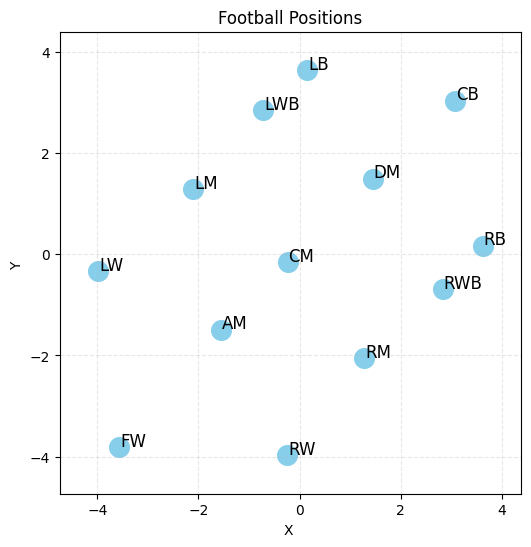

In [37]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

def positions_to_coords(dist_dict, n_dim=2, random_state=42):
    """
    将位置间距离规则映射成坐标。
    
    参数：
    - dist_dict: dict, 形如 {('ST','CF'):0.1, ('ST','CB'):1.0, ...}，表示已知距离
    - n_dim: int, 坐标维度
    - random_state: int, 随机种子
    
    返回：
    - pos_coords: dict, 位置->坐标 ndarray
    """
    # 1. 获取所有位置
    positions = sorted({p for pair in dist_dict.keys() for p in pair})
    n_pos = len(positions)
    pos_index = {p:i for i,p in enumerate(positions)}
    
    # 2. 构建完整距离矩阵（未知距离用较大值或平均值）
    dist_matrix = np.zeros((n_pos,n_pos))
    for i in range(n_pos):
        for j in range(n_pos):
            if i == j:
                dist_matrix[i,j] = 0
            else:
                key1 = (positions[i], positions[j])
                key2 = (positions[j], positions[i])
                if key1 in dist_dict:
                    dist_matrix[i,j] = dist_dict[key1]
                elif key2 in dist_dict:
                    dist_matrix[i,j] = dist_dict[key2]
                else:
                    dist_matrix[i,j] = 1.0  # 默认距离，可根据需要调整

    # 3. MDS映射
    mds = MDS(n_components=n_dim, dissimilarity='precomputed', random_state=random_state)
    coords = mds.fit_transform(dist_matrix)
    
    # 4. 输出字典
    pos_coords = {p: coords[pos_index[p]] for p in positions}
    return pos_coords

coords = positions_to_coords(distances, n_dim=2)
for k,v in coords.items():
    print(k, v)
# 提取所有 x, y
xs = [x for x, y in coords.values()]
ys = [y for x, y in coords.values()]

# 创建图
plt.figure(figsize=(8,6))
plt.title("Football Positions")
plt.xlabel("X ")
plt.ylabel("Y ")

# 画每个位置
for pos, (x, y) in coords.items():
    plt.scatter(x, y, s=200, c='skyblue')
    plt.text(x+0.02, y+0.02, pos, fontsize=12)

# 自动设置坐标范围并加边距
x_margin = (max(xs)-min(xs))*0.1
y_margin = (max(ys)-min(ys))*0.1
plt.xlim(min(xs)-x_margin, max(xs)+x_margin)
plt.ylim(min(ys)-y_margin, max(ys)+y_margin)

plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()


In [ ]:
import math

# 对称化距离字典
sym_distances = {}
for (a,b), d in distances.items():
    sym_distances[(a,b)] = d
    sym_distances[(b,a)] = d
    sym_distances[(a,a)] = 0
    sym_distances[(b,b)] = 0

def weighted_posset_distance(setA, setB, weightsA, weightsB, default_distance=10):
    """
    计算两个球员位置集合的加权距离
    setA, setB: list of position
    weightsA, weightsB: dict，位置 -> 熟练比重
    """
    if not setA or not setB:
        return float('inf')
    
    total_dist = 0
    for a in setA:
        for b in setB:
            dist = sym_distances.get((a,b), default_distance)
            total_dist += dist * weightsA.get(a,0) * weightsB.get(b,0)
    return total_dist

def weighted_posset_similarity(setA, setB, weightsA, weightsB, alpha=0.5):
    d = weighted_posset_distance(setA, setB, weightsA, weightsB)
    return math.exp(-alpha*d)

# ------------------------------
# 示例
# ------------------------------
player1 = ['CB']
weights1 = {'CB':1}   # 熟练比重

player2 = ['CB','LB','RB']
weights2 = {'CB': 0.9719495091164095, 'LB': 0.02208976157082749, 'RB': 0.005960729312762973}

dist = weighted_posset_distance(player1, player2, weights1, weights2)
sim = weighted_posset_similarity(player1, player2, weights1, weights2)

print("加权集合距离:", dist)
print("加权集合相似度:", sim)


加权集合距离: 0.056100981767180924
加权集合相似度: 0.9723392712928622
加权集合距离1: 0
加权集合相似度1: 1.0


In [86]:
import math

# coords 是位置到坐标的映射
# 示例：
# coords = {
#     "CB": (0.75, -0.68),
#     "LB": (-0.48, 0.13),
#     ...
# }

def split_WB_posset(weights, posset):
    """
    将 WB 拆分成 LWB/RWB，更新 weights 和 posset
    weights: dict, 位置 -> 权重（含 WB）
    posset: list, 位置集合（含 WB）
    返回: (new_weights, new_posset)
    """
    w_WB = weights.get('WB', 0)
    if w_WB == 0:
        return weights, posset  # 没有 WB，直接返回

    # 定义左右位置集合
    left_positions = ['LB','LM','LW']
    right_positions = ['RB','RM','RW']

    total_L = sum(weights.get(p,0) for p in left_positions)
    total_R = sum(weights.get(p,0) for p in right_positions)
    total = total_L + total_R

    if total == 0:
        ratio_L, ratio_R = 0.5, 0.5
    else:
        ratio_L = total_L / total
        ratio_R = total_R / total

    # 拆分 WB 权重
    w_LWB = w_WB * ratio_L
    w_RWB = w_WB * ratio_R

    # 更新 weights
    new_weights = weights.copy()
    new_weights.pop('WB')
    if w_LWB > 0:
        new_weights['LWB'] = w_LWB
    if w_RWB > 0:
        new_weights['RWB'] = w_RWB

    # 更新 posset
    new_posset = [p for p in posset if p != 'WB']
    if w_LWB > 0:
        new_posset.append('LWB')
    if w_RWB > 0:
        new_posset.append('RWB')

    return new_weights, new_posset



def player_weighted_coord(posset, weights, coords=coords):
    """
    计算球员加权坐标
    posset: list of 位置字符串
    weights: dict, 位置 -> 权重
    coords: dict, 位置 -> (x,y) 坐标
    """
    weights, posset = split_WB_posset(weights,posset)
    total_weight = sum(weights.get(p, 0) for p in posset)
    if total_weight == 0:
        return (0,0)
    
    x = sum(coords[p][0] * weights.get(p, 0) for p in posset) / total_weight
    y = sum(coords[p][1] * weights.get(p, 0) for p in posset) / total_weight
    return (x, y)

def weighted_coord_similarity(possetA, weightsA, possetB, weightsB, coords=coords, alpha=1.0):
    """
    基于加权坐标的欧氏距离计算相似度
    """
    x1, y1 = player_weighted_coord(possetA, weightsA, coords)
    x2, y2 = player_weighted_coord(possetB, weightsB, coords)
    dist = math.sqrt((x1-x2)**2 + (y1-y2)**2)
    return math.exp(-alpha*dist)

# ------------------------------
# 示例
# ------------------------------
player1_pos = ['CB']
player1_weights = {'CB': 1}

player2_pos = ['CB','LB','RB']
player2_weights = {'CB': 0.97, 'LB': 0.02, 'RB': 0.01}

sim = weighted_coord_similarity(player1_pos, player1_weights,
                                player2_pos, player2_weights,
                                coords, alpha=1.5)

print("基于加权坐标的相似度:", sim)


基于加权坐标的相似度: 0.9203365512608005


In [ ]:
import pandas as pd
import itertools
import math

# -----------------------------
# 假设 sym_distances 已定义
# posset_distance_weighted 和 posset_similarity_weighted 已定义
# -----------------------------

# 读取 CSV
df = pd.read_csv("player_features.csv")
df['Pos_set'] = df['Pos_set'].astype(str)

# 示例球员列表
player_names = ["Bukayo Saka", "Jakub Kiwior", "Nicolas Jackson", 
                "Amadou Onana", "Ryan Gravenberch", "Mohamed Salah", "Virgil van Dijk"]

# 构建球员到 Pos_set 和 Pos_weights 的映射
player_possets = {}
player_posweights = {}
for _, row in df.iterrows():
    name = row['name']
    if name not in player_names:
        continue
    # Pos_set
    pos_list = row['Pos_set'].split(', ') if pd.notna(row['Pos_set']) else []
    player_possets[name] = pos_list
    # Pos_weights
    try:
        weights = eval(row['Pos_weights']) if pd.notna(row['Pos_weights']) else {}
    except:
        weights = {}
    player_posweights[name] = weights

# 保存相似度结果
similarities = []
similarities1 = []
# 两两组合计算加权相似度
for p1, p2 in itertools.combinations(player_names, 2):
    if p1 in player_possets and p2 in player_possets:
        set1 = player_possets[p1]
        set2 = player_possets[p2]
        weights1 = player_posweights.get(p1, None)
        if len(weights1) == 0:
            print(p1+" has no pos weight") 
            similarities.append((p1, p2, 0))
            continue
        weights2 = player_posweights.get(p2, None)
        if len(weights2) == 0:
            print(p2+" has no pos weight") 
            similarities.append((p1, p2, 0))
            continue

        sim1 = weighted_posset_similarity(set1, set2, weights1, weights2)
        sim = weighted_coord_similarity(set1, weights1,
                                set2, weights2)
        similarities.append((p1, p2, sim))
        similarities1.append((p1, p2, sim1))

# 按相似度从高到低排序
similarities_sorted = sorted(similarities, key=lambda x: x[2], reverse=True)
similarities_sorted1 = sorted(similarities1, key=lambda x: x[2], reverse=True)

# 输出结果
print("coord sim")
for p1, p2, sim in similarities_sorted:
    print(f"{p1} - {p2}: {sim:.4f}")
print("\nset sim")
for p1, p2, sim in similarities_sorted1:
    print(f"{p1} - {p2}: {sim:.4f}")


# KMeans

In [88]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import math

# ------------------------------
# 读取数据
# ------------------------------
df = pd.read_csv("player_features.csv")
# ------------------------------
# 列名分组
# ------------------------------

# 基础身体属性
physical_cols = [
    'height','weight','Footed'
]

# 防守指标
defense_cols = [
    'Tkl','TklW','Blocks','Int','Clr','Err','Tkl%','Tkl+Int','Def 3rd','Mid 3rd','Att 3rd'
]

# 进攻 / 传球指标
offense_cols = [
    'Sh','Pass','Att','Lost'
]

# 门将类指标（如果有）
gk_cols = [
    'SoTA','GA'
]

# 触球 / 控球指标（之前的也可以补进来）
possession_cols = [
    'Touches','Carries','PrgC','CPA','Mis','Dis','Rec','PrgR'
]

# 成功率
success_cols = ['Succ%','Tkld%']

other_cols = ['Pos_set','Pos_weights']

# 汇总
all_feature_cols = (
    physical_cols + defense_cols + offense_cols + 
    gk_cols + possession_cols + success_cols+other_cols
)

# 打印结果（便于直接复制）
print("聚类特征列:")
print(','.join(f"'{c}'" for c in all_feature_cols))


聚类特征列:
'height','weight','Footed','Tkl','TklW','Blocks','Int','Clr','Err','Tkl%','Tkl+Int','Def 3rd','Mid 3rd','Att 3rd','Sh','Pass','Att','Lost','SoTA','GA','Touches','Carries','PrgC','CPA','Mis','Dis','Rec','PrgR','Succ%','Tkld%','Pos_set','Pos_weights'


In [118]:

posset_col = 'Pos_set'
# 预处理NaN
df[all_feature_cols] = df[all_feature_cols].fillna(0)
df[posset_col] = df[posset_col].astype(str)

# ------------------------------
# 忽略含GK的行
# ------------------------------
df_filtered = df[~df['Pos_set'].str.contains('GK')].copy()
df_filtered = df_filtered[~df_filtered['Pos_set'].str.contains('0')].copy()
footed_onehot = pd.get_dummies(df_filtered['Footed'], prefix='Footed')
df_filtered = pd.concat([df_filtered, footed_onehot], axis=1)

# 生成加权坐标
# def parse_posset(posset_str):
#     if pd.isna(posset_str) or posset_str.strip() == '':
#         return []
#     return [p.strip() for p in posset_str.split(',')]

# for _, row in df_filtered.iterrows():    
#     set = parse_posset(row['Pos_set'])
#     weight = eval(row['Pos_weights']) if pd.notna(row['Pos_weights']) else None
#     set = list(weights.keys())
#     print(set)
#     print(weight)
#     print(split_WB_posset(weight,set))
#     player_weighted_coord(
#         set,  # 这里返回 ['CB', 'LB']
#         weight
#     )

def parse_weights(weights_str):
    try:
        return eval(weights_str) if pd.notna(weights_str) else {}
    except:
        return {}

weighted_coords = np.array([
    player_weighted_coord(
        list(parse_weights(row['Pos_weights']).keys()),  # 用 weights 的 keys 作为 posset
        parse_weights(row['Pos_weights'])                # 权重字典
    )
    for _, row in df_filtered.iterrows()
])


# 数值列标准化
# 自动筛选数值列
numeric_cols = df_filtered.select_dtypes(include=np.number).columns.tolist()
X_num = df_filtered[numeric_cols].values
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)



# 特征矩阵
X = np.hstack([X_num_scaled, weighted_coords])

# 聚类
kmeans = KMeans(n_clusters=15, random_state=42)
labels = kmeans.fit_predict(X)

df_filtered['cluster'] = labels

# 输出结果
print(df_filtered[['name', posset_col, 'cluster']].head())
df_filtered.to_csv("player_features_clustered_noGK.csv", index=False)



             name                         Pos_set  cluster
1    Andre Annous                          AM, FW        2
2    Ayden Heaven                          CB, LB       11
3       Ben White                      CB, LB, RB        1
4  Brayden Clarke                          CB, RB        7
5     Bukayo Saka  AM, CM, FW, LM, LW, RM, RW, WB        8


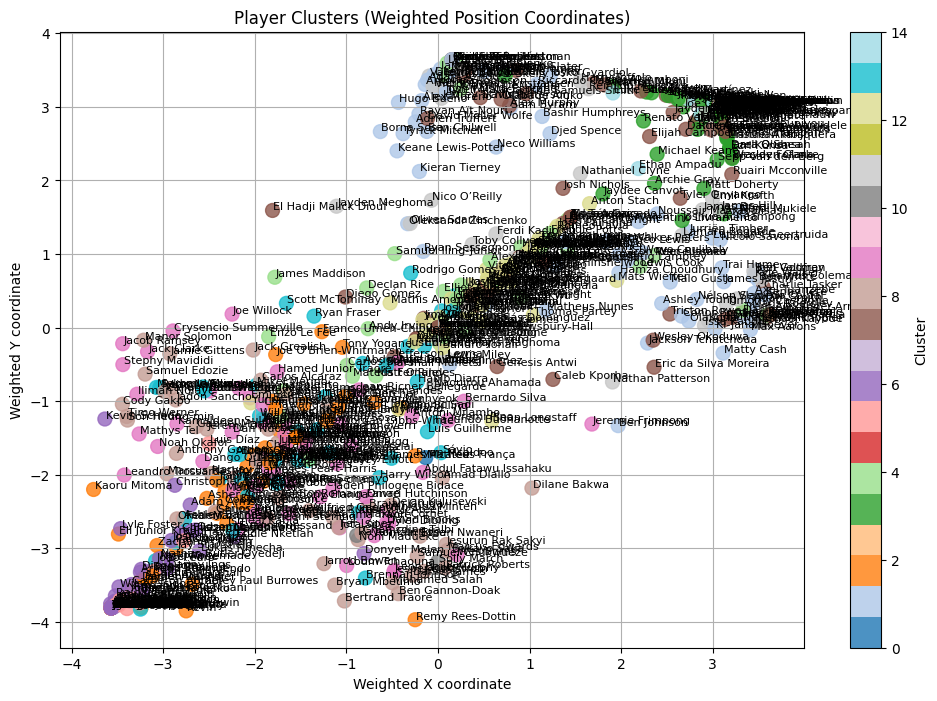

In [119]:
import matplotlib.pyplot as plt

# 假设 weighted_coords 已经是每个球员的加权坐标 (x, y)
# labels 是聚类标签
x = weighted_coords[:, 0]
y = weighted_coords[:, 1]

plt.figure(figsize=(12, 8))
scatter = plt.scatter(x, y, c=df_filtered['cluster'], cmap='tab20', s=100, alpha=0.8)

# 给每个点标上球员名字
for i, name in enumerate(df_filtered['name']):
    plt.text(x[i]+0.01, y[i]+0.01, name, fontsize=8)

plt.xlabel('Weighted X coordinate')
plt.ylabel('Weighted Y coordinate')
plt.title('Player Clusters (Weighted Position Coordinates)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


In [120]:
import json

# 按 cluster 分组，并选取最多 10 个球员
clustered_sample = {}
for cluster_id, group in df_filtered.groupby('cluster'):
    sample = group.sample(n=min(5, len(group)), random_state=42)
    # 只保留你需要的信息，比如 name 和 Pos_set
    clustered_sample[cluster_id] = sample[['name', 'Pos_set']].to_dict(orient='records')

# 写入 JSON 文件
with open('clustered_sample.json', 'w', encoding='utf-8') as f:
    json.dump(clustered_sample, f, ensure_ascii=False, indent=4)

print("JSON 文件已生成：clustered_sample.json")


JSON 文件已生成：clustered_sample.json
